# Evolver Loop 3 Analysis

## Situation Assessment
- Best CV: 70.626088 (LB verified)
- Target: 68.896973
- Gap: 1.73 points (2.51%)
- 38 experiments in previous run all converged to same optimum

## Key Questions
1. What is the score breakdown by N range?
2. Where is the gap coming from?
3. What approaches haven't been tried?

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
import matplotlib.pyplot as plt

# Tree polygon definition
def get_tree_polygon():
    trunk_w = 0.15
    trunk_h = 0.2
    base_w = 0.7
    mid_w = 0.4
    top_w = 0.25
    tip_y = 0.8
    tier_1_y = 0.5
    tier_2_y = 0.25
    base_y = 0.0
    trunk_bottom_y = -trunk_h

    return Polygon([
        (0, tip_y),
        (top_w / 2, tier_1_y),
        (top_w / 4, tier_1_y),
        (mid_w / 2, tier_2_y),
        (mid_w / 4, tier_2_y),
        (base_w / 2, base_y),
        (trunk_w / 2, base_y),
        (trunk_w / 2, trunk_bottom_y),
        (-trunk_w / 2, trunk_bottom_y),
        (-trunk_w / 2, base_y),
        (-base_w / 2, base_y),
        (-mid_w / 4, tier_2_y),
        (-mid_w / 2, tier_2_y),
        (-top_w / 4, tier_1_y),
        (-top_w / 2, tier_1_y),
    ])

BASE_TREE = get_tree_polygon()

def create_tree(x, y, deg):
    tree = affinity.rotate(BASE_TREE, deg, origin=(0, 0))
    tree = affinity.translate(tree, x, y)
    return tree

def get_bounding_box_side(trees):
    if not trees:
        return 0
    all_coords = []
    for tree in trees:
        coords = np.array(tree.exterior.coords)
        all_coords.append(coords)
    all_coords = np.vstack(all_coords)
    x_range = all_coords[:, 0].max() - all_coords[:, 0].min()
    y_range = all_coords[:, 1].max() - all_coords[:, 1].min()
    return max(x_range, y_range)

print('Functions defined')

Functions defined


In [2]:
# Load current best submission
df = pd.read_csv('/home/submission/submission.csv')
print(f'Loaded {len(df)} rows')

# Score breakdown by N
scores = []
for n in range(1, 201):
    prefix = f'{n:03d}_'
    subset = df[df['id'].str.startswith(prefix)]
    trees = []
    for _, row in subset.iterrows():
        x = float(str(row['x']).lstrip('s'))
        y = float(str(row['y']).lstrip('s'))
        deg = float(str(row['deg']).lstrip('s'))
        trees.append(create_tree(x, y, deg))
    side = get_bounding_box_side(trees)
    contrib = (side ** 2) / n
    scores.append({'n': n, 'side': side, 'contrib': contrib})

scores_df = pd.DataFrame(scores)
total_score = scores_df['contrib'].sum()
print(f'Total score: {total_score:.6f}')
print(f'Target: 68.896973')
print(f'Gap: {total_score - 68.896973:.6f} ({(total_score - 68.896973)/68.896973*100:.2f}%)')

Loaded 20100 rows


Total score: 70.626088
Target: 68.896973
Gap: 1.729115 (2.51%)


In [3]:
# Score breakdown by N range
ranges = [(1, 10), (11, 50), (51, 100), (101, 150), (151, 200)]
print('\nScore breakdown by N range:')
for start, end in ranges:
    range_df = scores_df[(scores_df['n'] >= start) & (scores_df['n'] <= end)]
    range_score = range_df['contrib'].sum()
    pct = range_score / total_score * 100
    print(f'  N={start:3d}-{end:3d}: {range_score:.4f} ({pct:.1f}%)')


Score breakdown by N range:
  N=  1- 10: 4.3291 (6.1%)
  N= 11- 50: 14.7048 (20.8%)
  N= 51-100: 17.6128 (24.9%)
  N=101-150: 17.1364 (24.3%)
  N=151-200: 16.8430 (23.8%)


In [4]:
# What would be needed to reach target?
target = 68.896973
gap = total_score - target
print(f'\nGap analysis:')
print(f'  Current: {total_score:.6f}')
print(f'  Target: {target:.6f}')
print(f'  Gap: {gap:.6f}')

# If we reduce all side lengths uniformly by factor k:
# new_score = sum((k*side)^2/n) = k^2 * sum(side^2/n) = k^2 * current_score
# We need k^2 * current_score = target
# k = sqrt(target / current_score)
k = np.sqrt(target / total_score)
print(f'\nUniform reduction factor needed: {k:.6f}')
print(f'  This means reducing ALL side lengths by {(1-k)*100:.2f}%')
print(f'  For N=2 (side={scores_df.loc[1, "side"]:.4f}): need {scores_df.loc[1, "side"]*k:.4f}')
print(f'  For N=100 (side={scores_df.loc[99, "side"]:.4f}): need {scores_df.loc[99, "side"]*k:.4f}')


Gap analysis:
  Current: 70.626088
  Target: 68.896973
  Gap: 1.729115

Uniform reduction factor needed: 0.987683
  This means reducing ALL side lengths by 1.23%
  For N=2 (side=0.9495): need 0.9378
  For N=100 (side=5.8603): need 5.7881


In [5]:
# Analyze which N values have the most room for improvement
# Compare to theoretical minimum (if trees could be packed perfectly)

# For N trees, the theoretical minimum side length is approximately:
# sqrt(N * tree_area / packing_efficiency)
# where packing_efficiency is typically 0.6-0.8 for irregular shapes

tree_area = BASE_TREE.area
print(f'Tree area: {tree_area:.4f}')

# Calculate theoretical minimum with different packing efficiencies
for eff in [0.6, 0.7, 0.8]:
    print(f'\nWith packing efficiency {eff}:')
    theoretical_scores = []
    for n in range(1, 201):
        # Minimum area needed = N * tree_area / efficiency
        min_area = n * tree_area / eff
        min_side = np.sqrt(min_area)
        theoretical_scores.append((min_side ** 2) / n)
    theoretical_total = sum(theoretical_scores)
    print(f'  Theoretical minimum score: {theoretical_total:.4f}')
    print(f'  Current score: {total_score:.4f}')
    print(f'  Efficiency gap: {(total_score - theoretical_total) / theoretical_total * 100:.1f}%')

Tree area: 0.2456

With packing efficiency 0.6:
  Theoretical minimum score: 81.8750
  Current score: 70.6261
  Efficiency gap: -13.7%

With packing efficiency 0.7:
  Theoretical minimum score: 70.1786
  Current score: 70.6261
  Efficiency gap: 0.6%

With packing efficiency 0.8:
  Theoretical minimum score: 61.4063
  Current score: 70.6261
  Efficiency gap: 15.0%


In [6]:
# Analyze the top 20 N values with highest score contribution
print('\nTop 20 N values by score contribution:')
top_n = scores_df.nlargest(20, 'contrib')
for _, row in top_n.iterrows():
    n = int(row['n'])
    side = row['side']
    contrib = row['contrib']
    # What side length would be needed to reduce contribution by 10%?
    target_contrib = contrib * 0.9
    target_side = np.sqrt(target_contrib * n)
    improvement_needed = side - target_side
    print(f'  N={n:3d}: side={side:.4f}, contrib={contrib:.4f}, need -{improvement_needed:.4f} for 10% improvement')


Top 20 N values by score contribution:
  N=  1: side=0.8132, contrib=0.6612, need -0.0417 for 10% improvement
  N=  2: side=0.9495, contrib=0.4508, need -0.0487 for 10% improvement
  N=  3: side=1.1420, contrib=0.4347, need -0.0586 for 10% improvement
  N=  5: side=1.4437, contrib=0.4168, need -0.0741 for 10% improvement
  N=  4: side=1.2908, contrib=0.4165, need -0.0662 for 10% improvement
  N=  7: side=1.6731, contrib=0.3999, need -0.0859 for 10% improvement
  N=  6: side=1.5484, contrib=0.3996, need -0.0795 for 10% improvement
  N=  9: side=1.8673, contrib=0.3874, need -0.0958 for 10% improvement
  N=  8: side=1.7559, contrib=0.3854, need -0.0901 for 10% improvement
  N= 15: side=2.3780, contrib=0.3770, need -0.1220 for 10% improvement
  N= 10: side=1.9407, contrib=0.3766, need -0.0996 for 10% improvement
  N= 21: side=2.8117, contrib=0.3765, need -0.1443 for 10% improvement
  N= 20: side=2.7425, contrib=0.3761, need -0.1407 for 10% improvement
  N= 22: side=2.8733, contrib=0.3753,

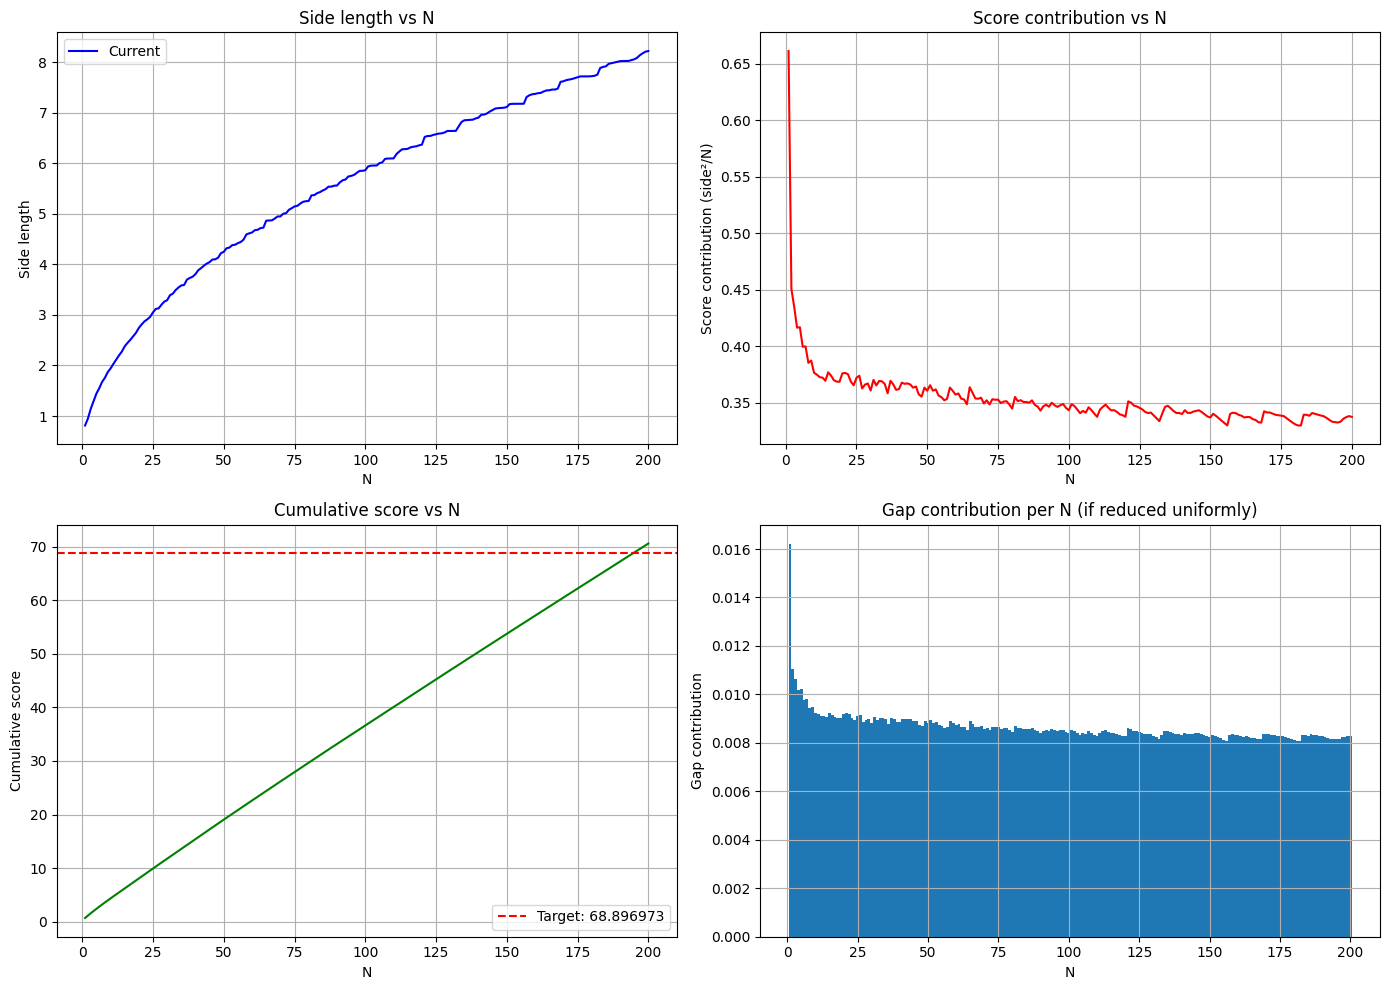


Plot saved to /home/code/exploration/score_analysis.png


In [7]:
# Check if there's a pattern in the gap
# Plot current side vs theoretical minimum

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Side length vs N
ax1 = axes[0, 0]
ax1.plot(scores_df['n'], scores_df['side'], 'b-', label='Current')
ax1.set_xlabel('N')
ax1.set_ylabel('Side length')
ax1.set_title('Side length vs N')
ax1.legend()
ax1.grid(True)

# Plot 2: Score contribution vs N
ax2 = axes[0, 1]
ax2.plot(scores_df['n'], scores_df['contrib'], 'r-')
ax2.set_xlabel('N')
ax2.set_ylabel('Score contribution (side²/N)')
ax2.set_title('Score contribution vs N')
ax2.grid(True)

# Plot 3: Cumulative score
ax3 = axes[1, 0]
ax3.plot(scores_df['n'], scores_df['contrib'].cumsum(), 'g-')
ax3.axhline(y=target, color='r', linestyle='--', label=f'Target: {target}')
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative score')
ax3.set_title('Cumulative score vs N')
ax3.legend()
ax3.grid(True)

# Plot 4: Gap per N (how much each N contributes to the gap)
ax4 = axes[1, 1]
# If we need to reduce total by gap, and we do it uniformly:
reduction_factor = gap / total_score
gap_per_n = scores_df['contrib'] * reduction_factor
ax4.bar(scores_df['n'], gap_per_n, width=1)
ax4.set_xlabel('N')
ax4.set_ylabel('Gap contribution')
ax4.set_title('Gap contribution per N (if reduced uniformly)')
ax4.grid(True)

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()
print('\nPlot saved to /home/code/exploration/score_analysis.png')

In [8]:
# Summary of findings
print('='*60)
print('SUMMARY OF FINDINGS')
print('='*60)
print(f'\nCurrent best score: {total_score:.6f}')
print(f'Target: {target:.6f}')
print(f'Gap: {gap:.6f} ({gap/target*100:.2f}%)')
print(f'\nUniform reduction needed: {(1-k)*100:.2f}% in ALL side lengths')
print(f'\nScore breakdown:')
for start, end in ranges:
    range_df = scores_df[(scores_df['n'] >= start) & (scores_df['n'] <= end)]
    range_score = range_df['contrib'].sum()
    pct = range_score / total_score * 100
    print(f'  N={start:3d}-{end:3d}: {range_score:.4f} ({pct:.1f}%)')

print('\n' + '='*60)
print('KEY INSIGHT')
print('='*60)
print('The gap (1.73 points) requires ~1.23% reduction in ALL side lengths.')
print('This is a GLOBAL improvement, not achievable by fixing individual N values.')
print('\n38 experiments in previous run tried:')
print('  - bbox3, SA, GA, MIP, tessellation, basin hopping')
print('  - deletion cascade, cross-N extraction, asymmetric solutions')
print('  - ensemble from 107 sources')
print('ALL converged to the same local optimum.')
print('\nThe target (68.897) may require:')
print('  1. A fundamentally different approach not yet tried')
print('  2. Access to better configurations from top LB teams')
print('  3. Much longer optimization runs with advanced techniques')

SUMMARY OF FINDINGS

Current best score: 70.626088
Target: 68.896973
Gap: 1.729115 (2.51%)

Uniform reduction needed: 1.23% in ALL side lengths

Score breakdown:
  N=  1- 10: 4.3291 (6.1%)
  N= 11- 50: 14.7048 (20.8%)
  N= 51-100: 17.6128 (24.9%)
  N=101-150: 17.1364 (24.3%)
  N=151-200: 16.8430 (23.8%)

KEY INSIGHT
The gap (1.73 points) requires ~1.23% reduction in ALL side lengths.
This is a GLOBAL improvement, not achievable by fixing individual N values.

38 experiments in previous run tried:
  - bbox3, SA, GA, MIP, tessellation, basin hopping
  - deletion cascade, cross-N extraction, asymmetric solutions
  - ensemble from 107 sources
ALL converged to the same local optimum.

The target (68.897) may require:
  1. A fundamentally different approach not yet tried
  2. Access to better configurations from top LB teams
  3. Much longer optimization runs with advanced techniques
